In [52]:
import sys

sys.path.append("/home/carlos/Desktop/projects/diff-gnn")
import argparse

import models
import utils
import train
from explain import explainer, visualize_edges
import json

import numpy as np
import seaborn as sns
import torch
import networkx as nx
import seaborn as sns

import matplotlib.pyplot as plt

from torch_geometric.utils import to_networkx
from torch_geometric import seed_everything
from torch_geometric.data import Batch

# seed_everything(88)

from skimage.filters import threshold_otsu

In [53]:
import importlib

importlib.reload(utils)
importlib.reload(train)
importlib.reload(models)

<module 'models' from '/home/carlos/Desktop/projects/diff-gnn/models.py'>

In [54]:
# build model
json_dict = json.load(
    open(
        "/home/carlos/Desktop/projects/diff-gnn/logs/checkpoints/tag_0.ckpt.args.json",
        "r",
    )
)
args = argparse.Namespace(**json_dict)
args.model_path = "/home/carlos/Desktop/projects/diff-gnn/logs/checkpoints/tag_0.ckpt"
args.test = True
model = train.build_model(args)
device = utils.get_device()
model = model.eval()

Loading model from /home/carlos/Desktop/projects/diff-gnn/logs/checkpoints/tag_0.ckpt


In [55]:
npz = np.load(
    "/home/carlos/Desktop/projects/diff-gnn/datasets/HeLa_10000.t0-t12.chr1.obs_exp_qt.npz"
)
graphs_a, idx = utils.constGraphList(npz["t0_q30-chr1_p"], 31, 51, use_prcnt=0.5)
graphs_b = utils.constGraphList(
    npz["t12_q30-chr1_p"], 31, 51, maxNodesQ=41, idx_list=idx
)

In [56]:
as_list_ = []
bs_list_ = []
for g_A, g_B in zip(graphs_a, graphs_b):
    if g_B != None:
        as_list_.append(g_A)
        bs_list_.append(g_B)

as_ = Batch.from_data_list(as_list_)
bs_ = Batch.from_data_list(bs_list_)


as_.x = as_.x.type(torch.float32)
as_.edge_attr = as_.edge_attr.type(torch.float32)
as_ = as_.to(utils.get_device())

bs_.x = bs_.x.type(torch.float32)
bs_.edge_attr = bs_.edge_attr.type(torch.float32)
bs_ = bs_.to(utils.get_device())


model.eval()
with torch.no_grad():
    emb_as_ = model.emb_model(
        x=as_.x, edge_index=as_.edge_index, e=as_.edge_attr, batch=as_.batch
    )
    emb_bs_ = model.emb_model(
        x=bs_.x, edge_index=bs_.edge_index, e=bs_.edge_attr, batch=bs_.batch
    )
    pred = model(emb_as_, emb_bs_)
    pred = model.predict(pred)
    pred = model.clf_model(pred.unsqueeze(1))
    pred = pred.argmax(dim=-1)

g_idx = torch.where(pred == 0)  # [0][0].cpu().item()
g_idx

(tensor([20, 34, 38, 42, 44, 45, 47, 48, 55, 56], device='cuda:0'),)

In [57]:
g_idx = 48

as_ = Batch.from_data_list([as_list_[g_idx]])
bs_ = Batch.from_data_list([bs_list_[g_idx]])

as_.x = as_.x.type(torch.float32)
# as_.edge_attr = as_.edge_attr.type(torch.float32)
bs_.x = bs_.x.type(torch.float32)
# bs_.edge_attr = bs_.edge_attr.type(torch.float32)

as_ = as_.to(utils.get_device())
bs_ = bs_.to(utils.get_device())

In [58]:
model.eval()
with torch.no_grad():
    emb_as_ = model.emb_model(
        x=as_.x, edge_index=as_.edge_index, e=as_.edge_attr, batch=as_.batch
    )
    emb_bs_ = model.emb_model(
        x=bs_.x, edge_index=bs_.edge_index, e=bs_.edge_attr, batch=bs_.batch
    )
    pred = model(emb_as_, emb_bs_)
    pred = model.predict(pred)
    pred = model.clf_model(pred.unsqueeze(1))

In [59]:
explainer_ = explainer(model, bs_)
edge_mask = (
    explainer_.train_edge_masks(model, bs_, emb_as_, epoch=500).cpu().detach().numpy()
)

True


<Axes: ylabel='Count'>

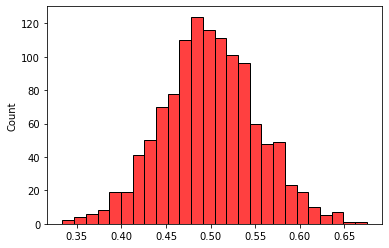

In [60]:
sns.histplot(edge_mask, fill=True, color="r", label="edge mask")

550 573


<Figure size 2400x960 with 0 Axes>

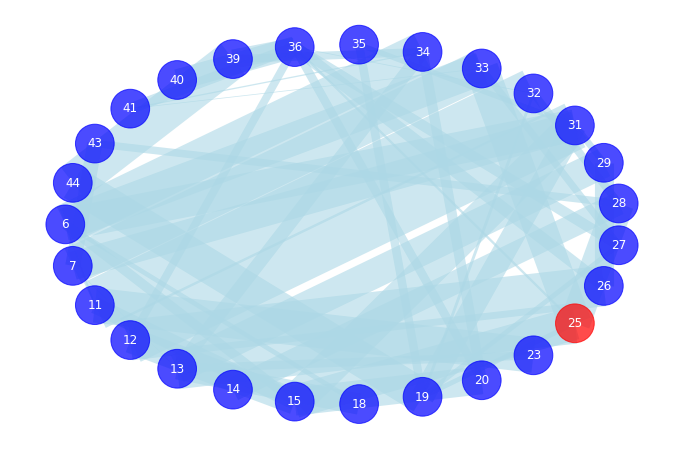

In [89]:
G_b = to_networkx(bs_, to_undirected=True, node_attrs=["x"], edge_attrs=["edge_attr"])

edges_to_keep = []

from skimage.filters import threshold_otsu

edge_T = threshold_otsu(edge_mask)
top = 50  # top n percent important edges
first_n = edge_mask.shape[0] // 100 * top

n_important_edges = np.where(edge_mask >= edge_T)[0].shape[0]
print(first_n, n_important_edges)
if first_n > n_important_edges:
    first_n = n_important_edges

edges_T_in_mask = np.argsort(edge_mask)[
    -first_n:
]  # top 5 percent important edges indexes
edges_T_in_mask = np.argsort(edge_mask)[:100]  # top 5 percent important edges indexes

bs_ = bs_.to("cpu")
for i, edge in enumerate(zip(*bs_.edge_index.numpy())):
    if i in edges_T_in_mask:
        edges_to_keep.append(set(edge))
for edge in G_b.edges():
    if set(edge) not in edges_to_keep:
        G_b.remove_edges_from([edge])


G_b = utils.relabel_nodes(G_b, 51)

fig = plt.figure(2, figsize=(40, 16), dpi=60)

G_b = nx.ego_graph(G_b, 25, radius=2).copy()


visualize_edges(G_b)

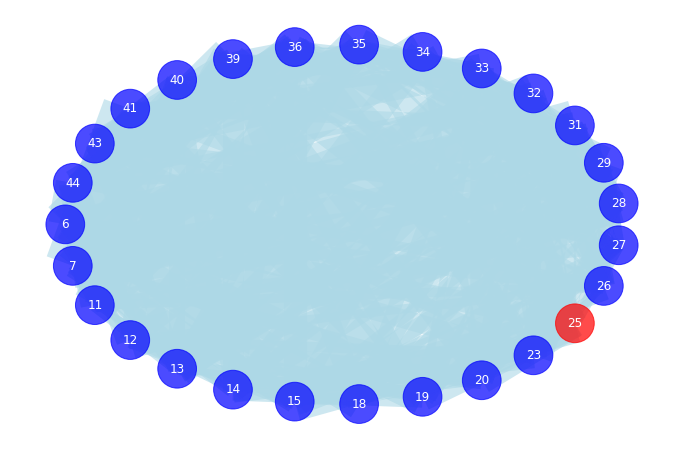

In [90]:
G_a = to_networkx(as_, to_undirected=True, node_attrs=["x"], edge_attrs=["edge_attr"])
G_a = utils.relabel_nodes(G_a, 51)

a_sub = G_a.subgraph(G_b.nodes).copy()
visualize_edges(a_sub)

In [91]:
G_a_edges = a_sub.to_directed().edges()
G_a_edges_data = list(a_sub.to_directed().edges(data=True))

for edge_B in G_b.edges(data=True):
    edge = (edge_B[0], edge_B[1])
    if edge in G_a_edges:
        i = list(G_a_edges).index(edge)
        b_attr = edge_B[2]["edge_attr"]
        a_attr = G_a_edges_data[i][2]["edge_attr"]
        diff = b_attr - a_attr
        if np.abs(diff) > 0.1 and 25 in edge:
            print(edge, b_attr - a_attr)

(19, 25) -0.23429836705327034
(25, 28) 0.3017656011506915
(25, 33) 0.1794821172952652
(25, 36) -0.22423668019473553


In [85]:
(33, 25) 0.1794821172952652
(36, 25) -0.22423668019473553
(19, 25) -0.23429836705327034
(25, 28) 0.3017656011506915

SyntaxError: invalid syntax (2947620002.py, line 1)